<a href="https://colab.research.google.com/github/IbraamSe/Stock-Trading-Bot-with-RL/blob/main/AI_Trading_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
!pip install stable-baselines3 gym-anytrading gym

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import gymnasium as gym
import gym_anytrading

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("kalilurrahman/nvidia-stock-data-latest-and-updated")

file_path = os.path.join(path, "NVidia_stock_history.csv")
df = pd.read_csv(file_path)


100%|██████████| 264k/264k [00:00<00:00, 440kB/s]

Extracting files...


In [ ]:
df["Date"] = pd.to_datetime(df["Date"], utc=True).dt.tz_localize(None)
df = df.drop(columns=['Dividends', 'Stock Splits'])
df.head()

,Date,Open,High,Low,Close,Volume
0,1999-01-22 05:00:00,0.040129,0.044786,0.035590,0.037621,2714688000
1,1999-01-25 05:00:00,0.040607,0.042039,0.037621,0.041562,510480000
2,1999-01-26 05:00:00,0.042039,0.042876,0.037740,0.038337,343200000
3,1999-01-27 05:00:00,0.038457,0.039412,0.036307,0.038218,244368000
4,1999-01-28 05:00:00,0.038218,0.038457,0.037859,0.038098,227520000


In [ ]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1999-01-22 05:00:00,0.040129,0.044786,0.035590,0.037621,2714688000
1999-01-25 05:00:00,0.040607,0.042039,0.037621,0.041562,510480000
1999-01-26 05:00:00,0.042039,0.042876,0.037740,0.038337,343200000
1999-01-27 05:00:00,0.038457,0.039412,0.036307,0.038218,244368000
1999-01-28 05:00:00,0.038218,0.038457,0.037859,0.038098,227520000


In [ ]:
env = gym.make('stocks-v0', df=df, frame_bound=(10,100), window_size=5)

info {'total_reward': 0.000715356320142746, 'total_profit': 0.7837824886977285, 'position': <Positions.Long: 1>}


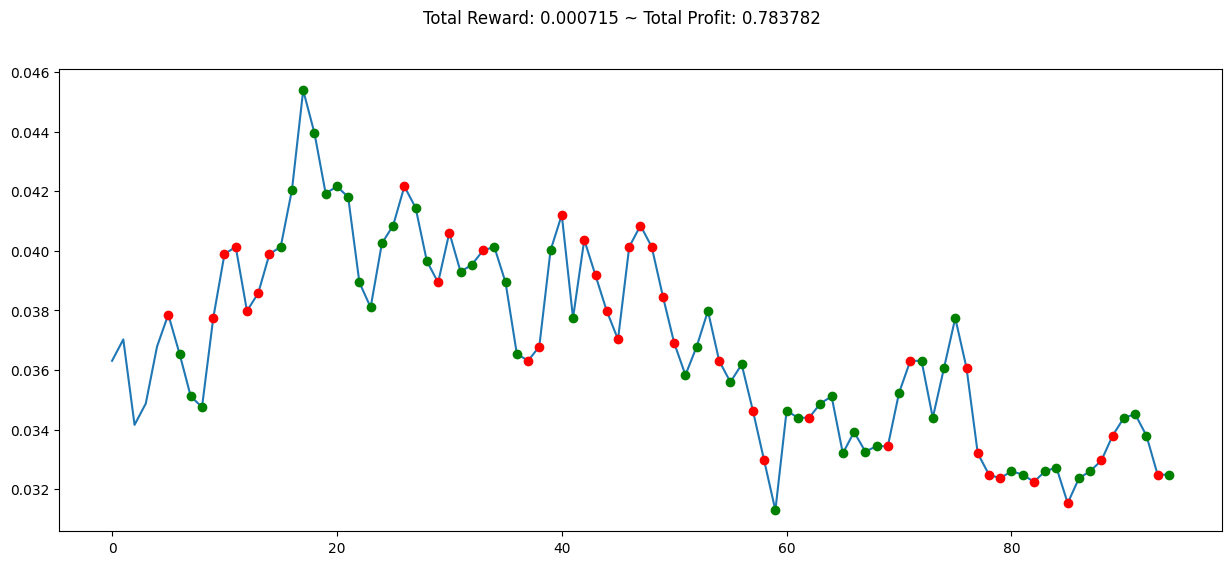

In [ ]:
# Sample Testing

state = env.reset()
while True:
    action = env.action_space.sample()
    n_state, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        print("info", info)
        break

env = env.unwrapped

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [ ]:
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

env_train = lambda: gym.make('gym_anytrading:stocks-v0', df=train_df, frame_bound=(5 ,train_size -1), window_size=5)
env_test = lambda: gym.make('gym_anytrading:stocks-v0', df=test_df, frame_bound=(5 , len(test_df) -1), window_size=5)

env_train = DummyVecEnv([env_train])
env_test = DummyVecEnv([env_test])

In [ ]:
model = A2C('MlpPolicy', env_train, verbose=1)
model.learn(total_timesteps=200000)

Using cuda device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
|    value_loss         | 6.84e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 413      |
|    iterations         | 4400     |
|    time_elapsed       | 53       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | -0.57    |
|    learning_rate      | 0.0007   |
|    n_updates          | 4399     |
|    policy_loss        | 0.00493  |
|    value_loss         | 6.01e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 413      |
|    iterations         | 4500     |
|    time_elapsed       | 54       |
|    total_timesteps    | 22500    |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | -1.63    |
|    learning_rate      

info {'total_reward': 0.22473695874214172, 'total_profit': 4.080015074394989, 'position': <Positions.Long: 1>}


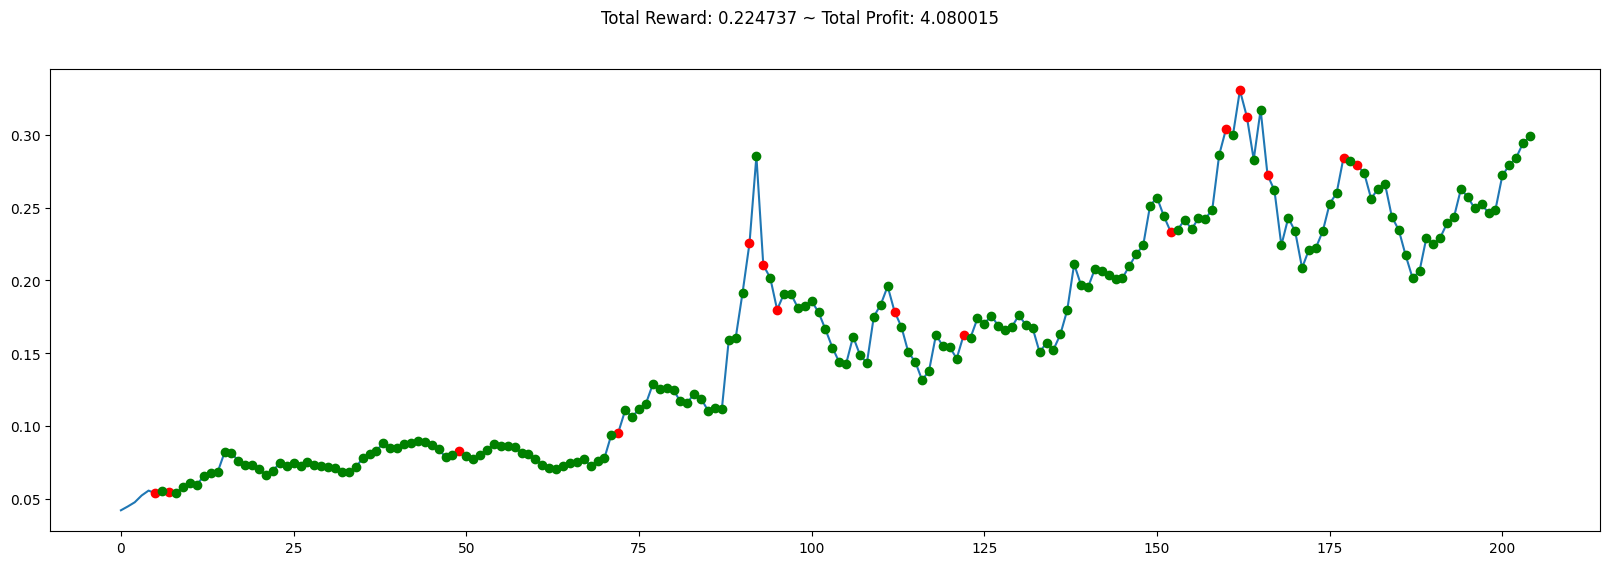

In [ ]:
env_test = gym.make('gym_anytrading:stocks-v0', df=df, frame_bound=(200,400), window_size=5)
obs, _ = env_test.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, truncated, info = env_test.step(action)
    if done or truncated:
        print("info", info)
        break

env_test = env_test.unwrapped
plt.figure(figsize=(20,6))
plt.cla()
env_test.render_all()
plt.show()

In [ ]:
from stable_baselines3 import PPO
model_2 = PPO('MlpPolicy', env_train, verbose=1)
model_2.learn(total_timesteps=200000)

Using cuda device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 684  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 549         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009323746 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.688      |
|    explained_variance   | 0.299       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0229     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00303    |
|    value_loss           | 0.000397    |
-----------------------------------------
----------------------------------

info {'total_reward': 0.2499680295586586, 'total_profit': 4.754406565278178, 'position': <Positions.Long: 1>}


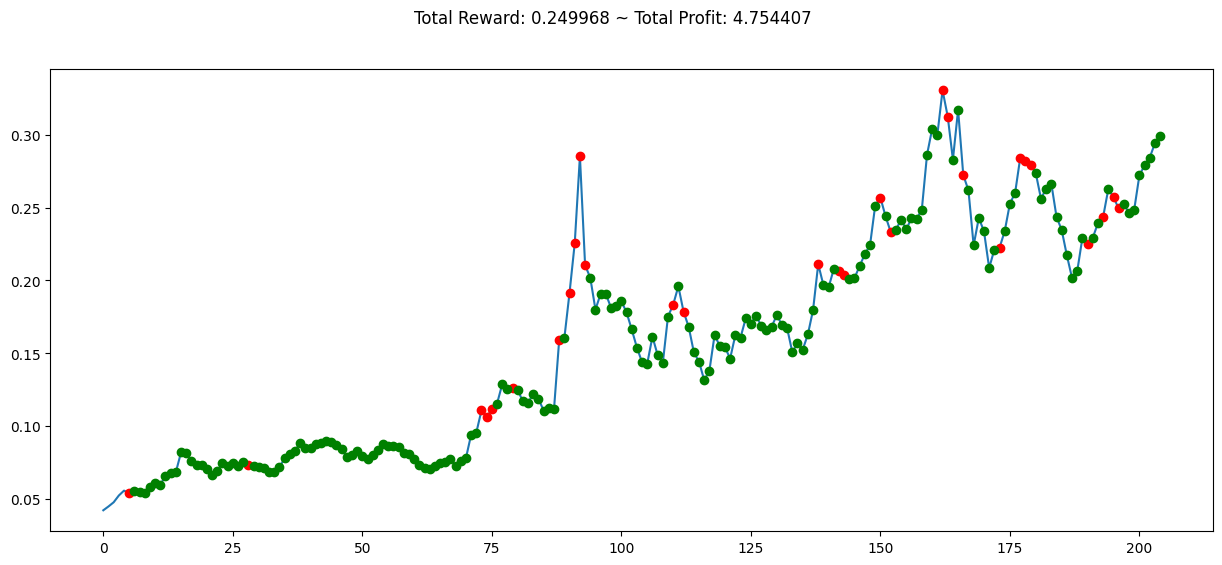

In [ ]:
env_test = gym.make('gym_anytrading:stocks-v0', df=df, frame_bound=(200, 400), window_size=5)
obs, _ = env_test.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model_2.predict(obs)
    obs, rewards, done, truncated, info = env_test.step(action)
    if done or truncated:
        print("info", info)
        break

env_test = env_test.unwrapped
plt.figure(figsize=(15,6))
plt.cla()
env_test.render_all()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_path = "/content/drive/MyDrive/Machine_Learning/ML_Models/AI_Trading_Bot"

# Save the model
model.save(model_path)